<a href="https://colab.research.google.com/github/Otobi1/Back-to-Basics-A-Refresher-/blob/master/Back_to_Basics_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# Embeddings 
# - these are capable of capturing the contextual, semantic and syntatic meaning in data.

# While one-hot encoding allows us to preserve the structural info, it has two disadvantages 
# 1. linearly dependent on the number of unique token in the vocab which is problem if we have a large corpus
# 2. the representation for each token does not preserve any relationship with respect to other tokens

# Embeddings address the short comings of one-hot encoding
# - its main idea is to have fixed length representations for the tokens in a text regardless of the tokens in the vocab
# with one-hot encoding, each token is represented by an array of size vocab size but with embeddings, each token now has the shape embed dim
###- the values in the rep are not fixed binary values but rather changing floating points allowing for fine-grained learned reps

# the objective here is to rep tokens in text that capture the intrinsic semantic relationships
## leveraging the low-dimensionality while capturing relationships and interpretable token reps.

In [55]:
# Learning Embeddings 
# - We can learn embeddings by creating our model in PyTorch, but first, we're going to use a library that specialises in embeddings and topic modelling called Gensim

import nltk
nltk.download('punkt');
import numpy as np
import re
import urllib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
SEED = 1234

In [57]:
# Set seed for reproducibility 

np.random.seed(SEED)

In [58]:
# Split text into sentences 

tokeniser = nltk.data.load("tokenizers/punkt/english.pickle")
book = urllib.request.urlopen(url = "https://raw.githubusercontent.com/GokuMohandas/madewithml/main/datasets/harrypotter.txt")
sentences = tokeniser.tokenize(str(book.read()))
print (f"{len(sentences)} sentences")

12443 sentences


In [59]:
def preprocess(text):
  """Conditional preprocessing on our text."""
  # Lower
  text = text.lower()

  # Spacing and filters 
  text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
  text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric characters 
  text = re.sub(' +', ' ', text) # remove multiple spaces
  text = text.strip()

  # Separate into word tokens
  text = text.split(" ")

  return text

In [60]:
# Preprocess sentences
print (sentences[11])
sentences = [preprocess(sentence) for sentence in sentences]
print (sentences[11])

Snape nodded, but did not elaborate.
['snape', 'nodded', 'but', 'did', 'not', 'elaborate']


In [61]:
# How doe we learn the embeddings in the first place?
# The intuition behind embeddins is that the definition of a token depends NOT on the token itself, but on its context.
# - There are several ways of doing this. 
# -- given the word in context, predict the target word (CBOW - continous bag of words)
# -- given the target word, predict the context word (skip-gram)
# -- given a sequence of words, predict the next word(LM - language modelling)

# all these approaches involve the creation of data to train the model on. 
# Every word in a sentence becomes the target word and the context words are determined by a window
# we repeat this for every sentence in the corpus and this results in the training data for unsupervised taskk

# the idea is that similar target words will appear with similar contexts and we can learn this relationship by repeatedly training our model (wiht context and target) pairs

In [62]:
# Word2Vec

# working with large vocabs to learn embeddings can become complicated quickly
# Here, we can use the "negative sampling", which only updates the correct class and a few arbitrary incorrect classes 
# We can do this because of the large amoutn of training data where we will see the same word as the target class multiple times

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [63]:
EMBEDDING_DIM = 100
WINDOW = 5
MIN_COUNT = 3 # ignores all the words with total frequency lower than this
SKIP_GRAM = 1 # 0 = CBOW
NEGATIVE_SAMPLING = 20

In [64]:
# super fast because of optimised C code under the hood

w2v = Word2Vec(sentences = sentences, size = EMBEDDING_DIM, window = WINDOW,
               min_count = MIN_COUNT, sg = SKIP_GRAM, negative = NEGATIVE_SAMPLING)
print (w2v)

Word2Vec(vocab=4937, size=100, alpha=0.025)


In [65]:
# Vector for each word
w2v.wv.get_vector("potter")

array([ 0.01697466, -0.2866405 , -0.3008265 , -0.29403865, -0.22781292,
       -0.19741872, -0.0874659 ,  0.14124094,  0.58748853,  0.33553848,
       -0.240756  , -0.04006175, -0.13412021,  0.17894153, -0.14883168,
       -0.34405807,  0.27631482,  0.26866025, -0.5066555 ,  0.14108138,
       -0.13761571, -0.3687644 , -0.06418797,  0.18793695, -0.2570797 ,
        0.35075605,  0.13261083,  0.17419575, -0.05647279, -0.07211813,
        0.59689295,  0.55984116, -0.01833745, -0.45927507, -0.34138373,
       -0.0491113 ,  0.37332585, -0.3035386 , -0.4004415 , -0.06110671,
       -0.00195717, -0.10445888, -0.28035152, -0.16219528,  0.2807279 ,
        0.41262493,  0.0014628 , -0.35501745,  0.22529054, -0.25333297,
        0.11366666,  0.25780088,  0.03564634,  0.04202371,  0.02636017,
        0.04561004,  0.42189986,  0.01397108,  0.2692497 , -0.26579332,
       -0.0788378 , -0.10421843, -0.23964319,  0.12406243,  0.17855582,
        0.21702808, -0.31919608,  0.46681818, -0.22580583, -0.14

In [66]:
# Get nearest neighbours (excluding itself)

w2v.wv.most_similar(positive = "scar", topn = 5)

[('forehead', 0.9274433255195618),
 ('pain', 0.9227378368377686),
 ('mouth', 0.9116102457046509),
 ('prickling', 0.9068350195884705),
 ('heart', 0.8966714143753052)]

In [67]:
# Saving and loading 

w2v.wv.save_word2vec_format("model.bin", binary = True)
w2v = KeyedVectors.load_word2vec_format("model.bin", binary = True)

In [68]:
# FastText

# What happens if a word doesnt exist in the vocab?
# We could assign an "UNK" (unkown) token which is used for all OOV (out of vocab) words or we could use FastText, which uses character-level n-grams to embed a word
# This helps embed rare words, misspelled words and also words that don't exist in our corpus but are similar to words in our corpus

In [69]:
from gensim.models import FastText

In [70]:
# super fast because of the optimised C code under the hood

ft = FastText(sentences = sentences, size = EMBEDDING_DIM, window = WINDOW, 
              min_count = MIN_COUNT, sg = SKIP_GRAM, negative = NEGATIVE_SAMPLING)
print (ft)

FastText(vocab=4937, size=100, alpha=0.025)


In [71]:
# This word doesn't 'exist so the word2vec model will error out 

# w2v.wv.most_similar(positive = "scarring", topn = 5) # uncomment to check

In [72]:
# FastText on the other hand will use n-grams to embed an OOV word

ft.wv.most_similar(positive = "scarring", topn = 10)

[('prickling', 0.9862031936645508),
 ('shuddering', 0.982107937335968),
 ('heartstring', 0.9814382791519165),
 ('brandishing', 0.9805978536605835),
 ('rippling', 0.9801949858665466),
 ('muffling', 0.980065107345581),
 ('shimmering', 0.9799435138702393),
 ('crumbling', 0.9794167280197144),
 ('shivering', 0.9788283109664917),
 ('compressing', 0.9781619310379028)]

In [73]:
# Save and load 

ft.wv.save("model.bin")
ft = KeyedVectors.load("model.bin")

In [74]:
# Pretrained embeddings

# - we can learn embeddings from scratch as above but we can also leverage pretrained embeddings that have been trained on millions of docs. 
# Popular ones include Word2Vec (skip gram) or GloVe(global word word co-occurence)
# we can validate that these embeddings captured meaningful semantic relationships by confirming them 

from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

In [94]:
# Arguments 

EMBEDDING_DIM = 100

In [95]:
def plot_embeddings(words, embeddings, pca_results):
  for word in words:
    index = embeddings.index2word.index(word)
    plt.scatter(pca_results[index, 0], pca_results[index, 1])
    plt.annotate(word, xy = (pca_results[index, 0], pca_results[index, 1]))
  plt.show()

In [96]:
# Unzip the file (may a while)

resp = urlopen("http://nlp.stanford.edu/data/glove.6B.zip")
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [97]:
# Write embeddings to file 

embeddings_file = "glove.6B.{0}d.txt".format(EMBEDDING_DIM)
zipfile.extract(embeddings_file)

'/content/glove.6B.100d.txt'

In [98]:
# Preview of the GloVe embeddings file 

with open(embeddings_file, "r") as fp:
  line = next(fp)
  values = line.split()
  word = values[0]
  embedding = np.asarray(values[1:], dtype = "float32")
  print (f"word: {word}")
  print (f"embedding:\n{embedding}")
  print (f"embedding dim: {len(embedding)}")

word: the
embedding:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [99]:
# Save GloVe embeddings to local directory in word2vec format

word2vec_output_file = "{0}.word2vec".format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

(400000, 100)

In [100]:
# Load embeddings (may take a while)

glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary = False)

In [101]:
# (king - man) + woman = ?

glove.most_similar(positive = ["woman", "king"], negative = ["man"], topn = 5)

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438)]

In [102]:
# Get nearest neighbours (excluding itself)

glove.wv.most_similar(positive = "goku", topn = 5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


[('gohan', 0.7246542572975159),
 ('bulma', 0.6497020125389099),
 ('raistlin', 0.6443604230880737),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231324672698975)]

In [103]:
# Reduce dimensionality for plotting

X = glove[glove.wv.vocab]
pca = PCA(n_components = 2)
pca_results = pca.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


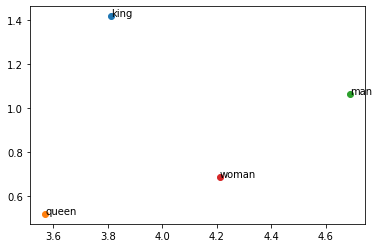

In [105]:
# Visualise 

plot_embeddings(words = ["king", "queen", "man", "woman"], 
                embeddings = glove, pca_results = pca_results)

In [106]:
# Bias in embeddings 

glove.most_similar(positive = ["woman", "doctor"], negative = ["man"], topn = 5)

[('nurse', 0.7735227346420288),
 ('physician', 0.7189429998397827),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033687591553)]